Load the model into a more intuitive graph structure using `OsimGraph`:

In [5]:
from src.osim_graph import OsimGraph
from loguru import logger
model_path = "models/RajagopalLaiUhlrich2023.osim"

graph = OsimGraph.from_file(model_path)

[info] Updating Model file from 40000 to latest format...
[info] Loaded model RajagopalLaiUhlrich2023 from file models/RajagopalLaiUhlrich2023.osim


Get the musculotendon lengths for the desired range of motion for each muscle

In [6]:
import polars as pl

# Specify muscles to analyze and number of lengths
muscles = {
    'gaslat_r': 100,
    'bflh_r': 100,
    'soleus_r': 100,
}

lengths: dict[str, pl.DataFrame] = {}
for muscle_name, num_lengths in muscles.items():
    try:
        lengths[muscle_name] = graph.get_muscle_lengths_rom(
            muscle_names=[muscle_name],
            min_points=num_lengths
        )
    except Exception as e:
        print(f"Muscle {muscle_name} not found in the model: {e}")

Plot the musculotendon lengths with respect to the coordinates

Creating coordinate-based visualizations:
gaslat_r: 3 coordinates - ['ankle_angle_r', 'knee_angle_r', 'subtalar_angle_r']
bflh_r: 4 coordinates - ['hip_rotation_r', 'hip_adduction_r', 'hip_flexion_r', 'knee_angle_r']
soleus_r: 2 coordinates - ['ankle_angle_r', 'subtalar_angle_r']

All unique coordinates: ['ankle_angle_r', 'hip_adduction_r', 'hip_flexion_r', 'hip_rotation_r', 'knee_angle_r', 'subtalar_angle_r']
Total number of unique coordinates: 6

gaslat_r - Top varying coordinates:
  knee_angle_r: range = 2.4435 rad
  ankle_angle_r: range = 1.7453 rad
  subtalar_angle_r: range = 1.2217 rad

bflh_r - Top varying coordinates:
  hip_flexion_r: range = 2.6180 rad
  knee_angle_r: range = 2.4435 rad
  hip_adduction_r: range = 1.3963 rad
  hip_rotation_r: range = 1.3963 rad

soleus_r - Top varying coordinates:
  ankle_angle_r: range = 1.7453 rad
  subtalar_angle_r: range = 1.2217 rad


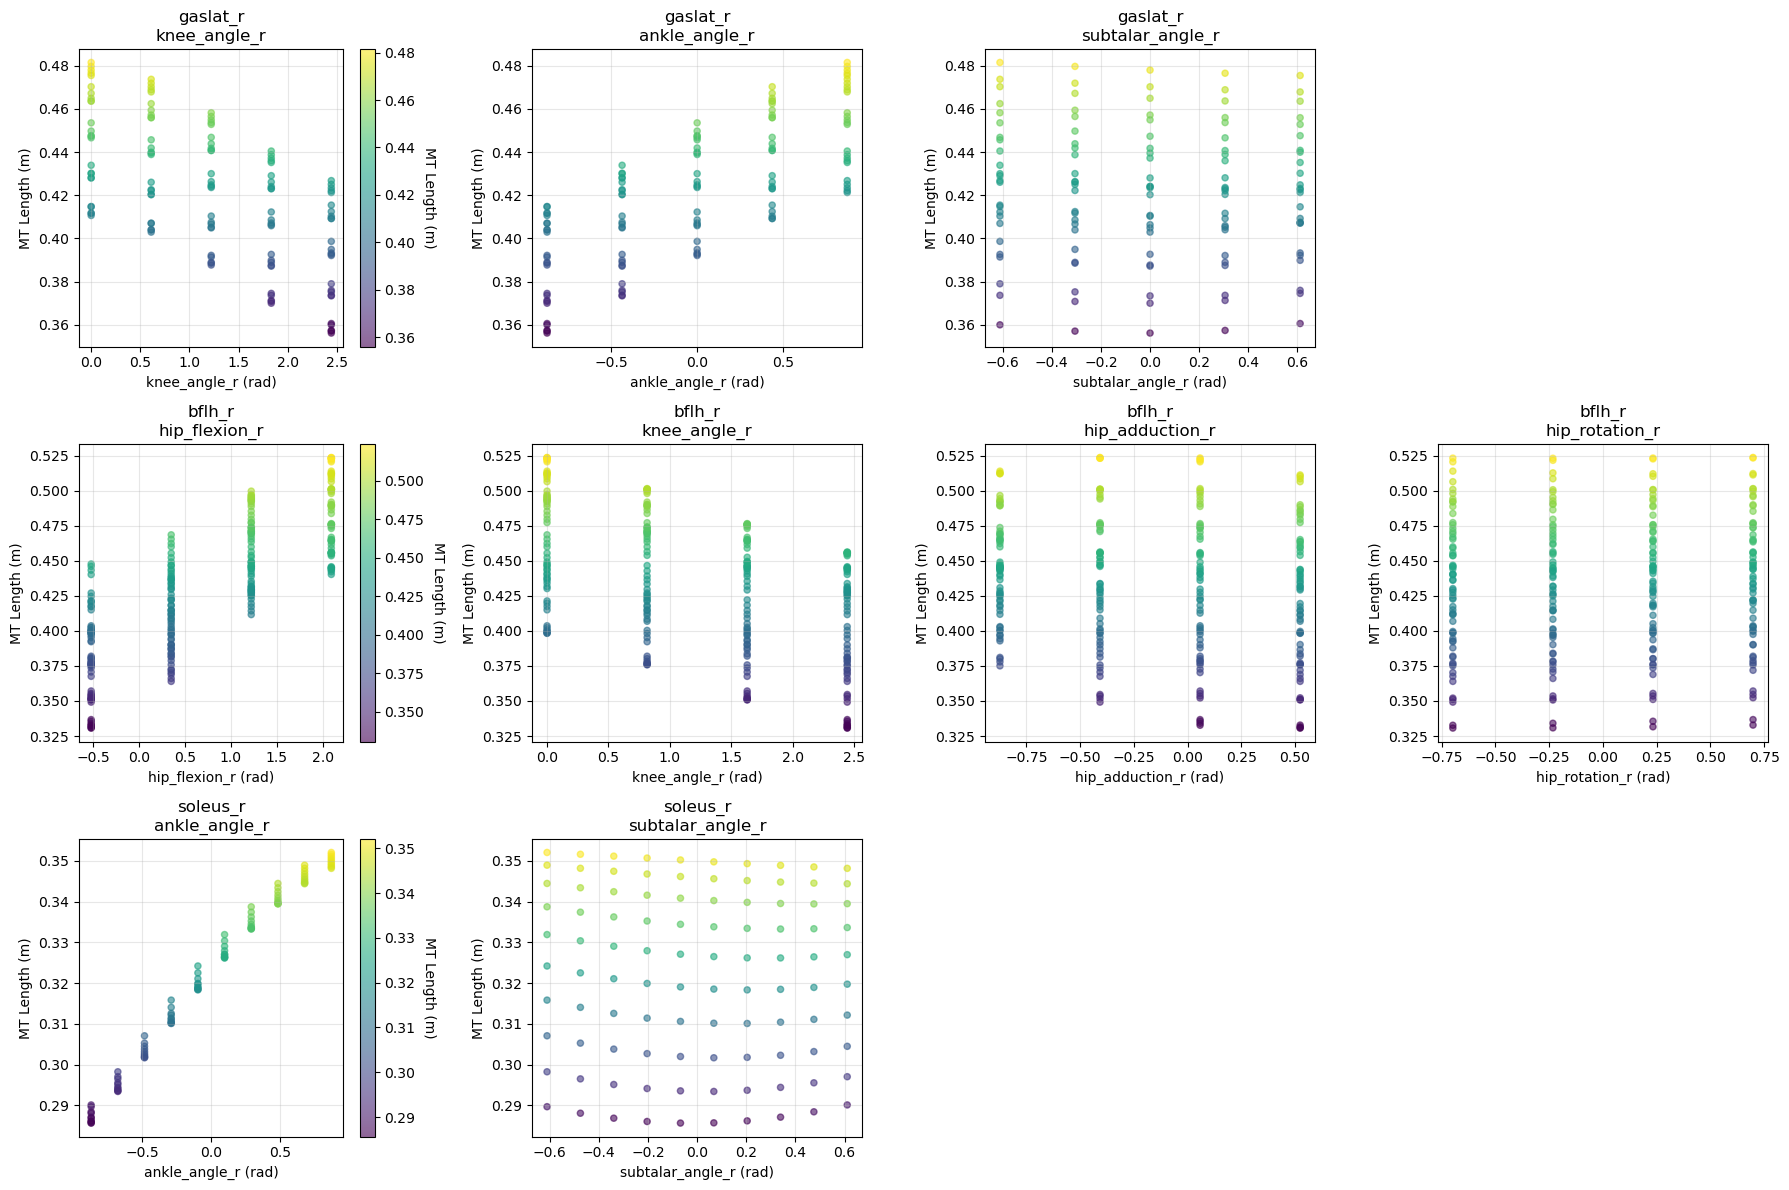


COORDINATE-MT LENGTH CORRELATION ANALYSIS

gaslat_r:
----------------------------------------
Top correlations (coordinate vs MT length):
  ankle_angle_r       : r =  0.7562
  knee_angle_r        : r = -0.6442
  subtalar_angle_r    : r = -0.0459

bflh_r:
----------------------------------------
Top correlations (coordinate vs MT length):
  hip_flexion_r       : r =  0.8102
  knee_angle_r        : r = -0.5237
  hip_adduction_r     : r = -0.1829
  hip_rotation_r      : r =  0.0447

soleus_r:
----------------------------------------
Top correlations (coordinate vs MT length):
  ankle_angle_r       : r =  0.9919
  subtalar_angle_r    : r = -0.0546


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualizations of musculotendon lengths vs coordinates
print("Creating coordinate-based visualizations:")
print("="*50)

# Let's examine the coordinate columns in more detail
coordinate_info = {}
for muscle_name, length_data in lengths.items():
    coords = [col for col in length_data.columns if col != muscle_name]
    coordinate_info[muscle_name] = coords
    print(f"{muscle_name}: {len(coords)} coordinates - {coords}")

# Find common and unique coordinates across muscles
all_coords = set()
for coords in coordinate_info.values():
    all_coords.update(coords)

print(f"\nAll unique coordinates: {sorted(list(all_coords))}")
print(f"Total number of unique coordinates: {len(all_coords)}")

# Create visualization strategy based on coordinate patterns
fig = plt.figure(figsize=(18, 12))

# Plot each muscle's MT length against its primary coordinates
subplot_rows = len(muscles)
subplot_cols = 4  # Show up to 4 most important coordinates per muscle

for muscle_idx, (muscle_name, length_data) in enumerate(lengths.items()):
    coords = coordinate_info[muscle_name]
    
    # Get the muscle length values
    mt_lengths = length_data.select(pl.col(muscle_name)).to_numpy().flatten()
    
    # Select the most varying coordinates (those with largest range)
    coord_ranges = {}
    for coord in coords:
        coord_values = length_data.select(pl.col(coord)).to_numpy().flatten()
        coord_ranges[coord] = np.max(coord_values) - np.min(coord_values)
    
    # Sort coordinates by their range (most varying first)
    sorted_coords = sorted(coord_ranges.items(), key=lambda x: x[1], reverse=True)
    top_coords = [coord for coord, _ in sorted_coords[:subplot_cols]]
    
    print(f"\n{muscle_name} - Top varying coordinates:")
    for coord, range_val in sorted_coords[:subplot_cols]:
        print(f"  {coord}: range = {range_val:.4f} rad")
    
    # Create subplots for this muscle's top coordinates
    for coord_idx, coord in enumerate(top_coords):
        plt.subplot(subplot_rows, subplot_cols, muscle_idx * subplot_cols + coord_idx + 1)
        
        coord_values = length_data.select(pl.col(coord)).to_numpy().flatten()
        
        # Create scatter plot with color-coding for MT length
        scatter = plt.scatter(coord_values, mt_lengths, c=mt_lengths, 
                            cmap='viridis', alpha=0.6, s=20)
        
        plt.xlabel(f'{coord} (rad)')
        plt.ylabel('MT Length (m)')
        plt.title(f'{muscle_name}\n{coord}')
        plt.grid(True, alpha=0.3)
        
        # Add colorbar for the first plot of each muscle
        if coord_idx == 0:
            cbar = plt.colorbar(scatter)
            cbar.set_label('MT Length (m)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


# Show correlation between coordinates and MT lengths
print("\n" + "="*60)
print("COORDINATE-MT LENGTH CORRELATION ANALYSIS")
print("="*60)

correlation_data = []
for muscle_name, length_data in lengths.items():
    coords = coordinate_info[muscle_name]
    mt_lengths = length_data.select(pl.col(muscle_name)).to_numpy().flatten()
    
    print(f"\n{muscle_name}:")
    print("-" * 40)
    
    correlations = {}
    for coord in coords:
        coord_values = length_data.select(pl.col(coord)).to_numpy().flatten()
        
        # Calculate correlation
        correlation = np.corrcoef(coord_values, mt_lengths)[0, 1]
        correlations[coord] = correlation
        
        correlation_data.append({
            'muscle': muscle_name,
            'coordinate': coord,
            'correlation': correlation,
            'coord_range': np.max(coord_values) - np.min(coord_values)
        })
    
    # Sort by absolute correlation
    sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print("Top correlations (coordinate vs MT length):")
    for coord, corr in sorted_corrs[:5]:  # Show top 5
        print(f"  {coord:20s}: r = {corr:7.4f}")


Optimize for tendon slack length

In [8]:
from src.tsl_optimization import optimize_fiber_length, ssdp, ssd
from src.muscle_params import calc_tsl
import opensim as osim
import numpy as np
import polars as pl

lm_norm_range = (0.4, 1.5)  # Normalized fiber length range
objectives = {'SSDP': ssdp,
            #   'SSD': ssd,
            #   'Var': lambda x: np.var(x),
            #   'Std': lambda x: np.std(x),
              }  # Objectives for optimization

muscle_data = {}
for muscle_name, lmt in lengths.items():
    muscle = graph.get_muscle(muscle_name)
    
    lm_opt = float(muscle.get_optimal_fiber_length())
    lm_range = lm_opt * np.asarray(lm_norm_range)
    alpha_opt = float(muscle.get_pennation_angle_at_optimal())
    lmt = np.clip(np.sort(np.unique(lmt.select(pl.col(muscle_name)))), 1e-6, None) # Ensure lmt is sorted, unique, and non-zero
    
    millard: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(muscle)
    afl = millard.getActiveForceLengthCurve()
    pfl = millard.getFiberForceLengthCurve()
    tfl = millard.getTendonForceLengthCurve()
    
    muscle_data[muscle_name] = {
        'lm_opt': lm_opt, 
        'alpha_opt': alpha_opt,
        'lm_range': lm_range
    }
    for obj_name, obj_func in objectives.items():
        # Optimize fiber length using the specified objective function
        lm = optimize_fiber_length(lmt, lm_opt, alpha_opt, afl, pfl, tfl, lm_norm_range, objective=obj_func)
        tsl = calc_tsl(lmt, lm, lm_opt, alpha_opt, afl, pfl, tfl)
        muscle_data[muscle_name][obj_name] = {
            'tsl': tsl, 
            'lm': lm, 
            'min_force': np.zeros_like(lm),
            'max_force': np.zeros_like(lm)
        }

Calculate the force that would be produced with each tendon slack length at the respective musculotendon lengths

In [9]:
import polars as pl

activations = [0.01, 1.0]

for muscle_name, lmt in lengths.items():
    lmt = lmt.sort(pl.col(muscle_name))
    for obj_name in objectives.keys():
        for activation in activations:
            coord_vals = lmt.select(pl.exclude(muscle_name))
            for t, values in zip(range(len(lmt)), coord_vals.to_numpy()):
                muscle = graph.get_muscle(muscle_name)
                muscle.set_tendon_slack_length(muscle_data[muscle_name][obj_name]['tsl'][t])
                # print(f"Setting TSL for {muscle_name} at point {t}: {muscle_data[muscle_name][obj_name]['tsl'][t]:.4f} m")
                s = graph.osim_model.initSystem()
                muscle.setActivation(s, activation)
                for coord, val in zip(coord_vals.columns, values):
                    graph.get_coordinate(coord).setValue(s, val)
                graph.osim_model.equilibrateMuscles(s)                
                graph.osim_model.realizeDynamics(s)
                muscle = graph.get_muscle(muscle_name)
                force = muscle.getTendonForce(s)
                muscle_data[muscle_name][obj_name]['max_force' if activation == 1.0 else 'min_force'][t] = force

Get the musculotendon lengths for walking, squatting, and cutting motions.

In [10]:
def sto_to_df(file_path: str) -> tuple[pl.DataFrame, dict[str, str]]:
    """
    Reads a .sto or .mot file and returns a Polars DataFrame.

    Args:
        file_path (str): Path to the .sto or .mot file.

    Returns:
        tuple: A tuple containing a Polars DataFrame with the data and a dictionary with metadata.
    """
    # Read the header of the file to determine number of lines to skip
    file_metadata = {"name": "", "comments": []}
    lines_to_skip = 1
    with open(file_path, "r") as f:
        line = f.readline()
        if "=" in line:
            key, value = line.split("=", 1)
            if key and value:
                file_metadata[key.lower()] = value.strip()
            line = f.readline()  # Read the next line after the key-value pair
            lines_to_skip += 1
        elif not line.startswith("endheader"):
            file_metadata["name"] = line.strip()
            line = f.readline()  # Second line should start the key value pairs
            lines_to_skip += 1
        else:  # If the first line is 'endheader', do not enter the loop
            file_metadata["name"] = "Unnamed File"
        while line and not line.startswith("endheader"):
            line = line.strip()
            if "=" in line:
                key, value = line.split("=", 1)
                if key and value:
                    file_metadata[key.lower()] = value.strip()
            elif line:  # Treat as a comment or empty line
                file_metadata["comments"].append(line)
            line = f.readline()  # Read until 'endheader'
            lines_to_skip += 1

    df = pl.read_csv(
        file_path, separator="\t", skip_lines=lines_to_skip, truncate_ragged_lines=True
    )
    # Strip whitespace from columns
    df = df.with_columns(
        [
            pl.col(col).cast(pl.String).str.strip_chars().cast(pl.Float64)
            for col in df.columns
        ]
    )
    return df, file_metadata

In [11]:
squatting_ik = 'data/Squatting_IK.mot'
cutting_ik = 'data/Cutting_IK.mot'
walking_ik = 'data/Walking_IK.mot'

squatting_df, squatting_meta = sto_to_df(squatting_ik)
cutting_df, cutting_meta = sto_to_df(cutting_ik)
walking_df, walking_meta = sto_to_df(walking_ik)

motion_data = {
    'squatting': {
        'df': squatting_df,
        'muscles':{}
    },
    'cutting': {
        'df': cutting_df,
        'muscles':{}
    },
    'walking': {
        'df': walking_df,
        'muscles':{}
    }
}

for muscle_name in muscles.keys():
    coords = graph.muscle_coords[muscle_name]
    for motion, motion_info in motion_data.items():
        coord_vals = motion_info['df'].select(pl.col(coords)) * 2 * np.pi / 180
        
        # Get the muscle lengths for this motion
        muscle_lengths = graph.get_muscle_lengths_from_data([muscle_name], coord_vals)
        
        motion_data[motion]['muscles'][muscle_name] = {
            'lengths': muscle_lengths,
            'min': muscle_lengths.select(pl.col(muscle_name)).min().item(),
            'max': muscle_lengths.select(pl.col(muscle_name)).max().item(),
        }


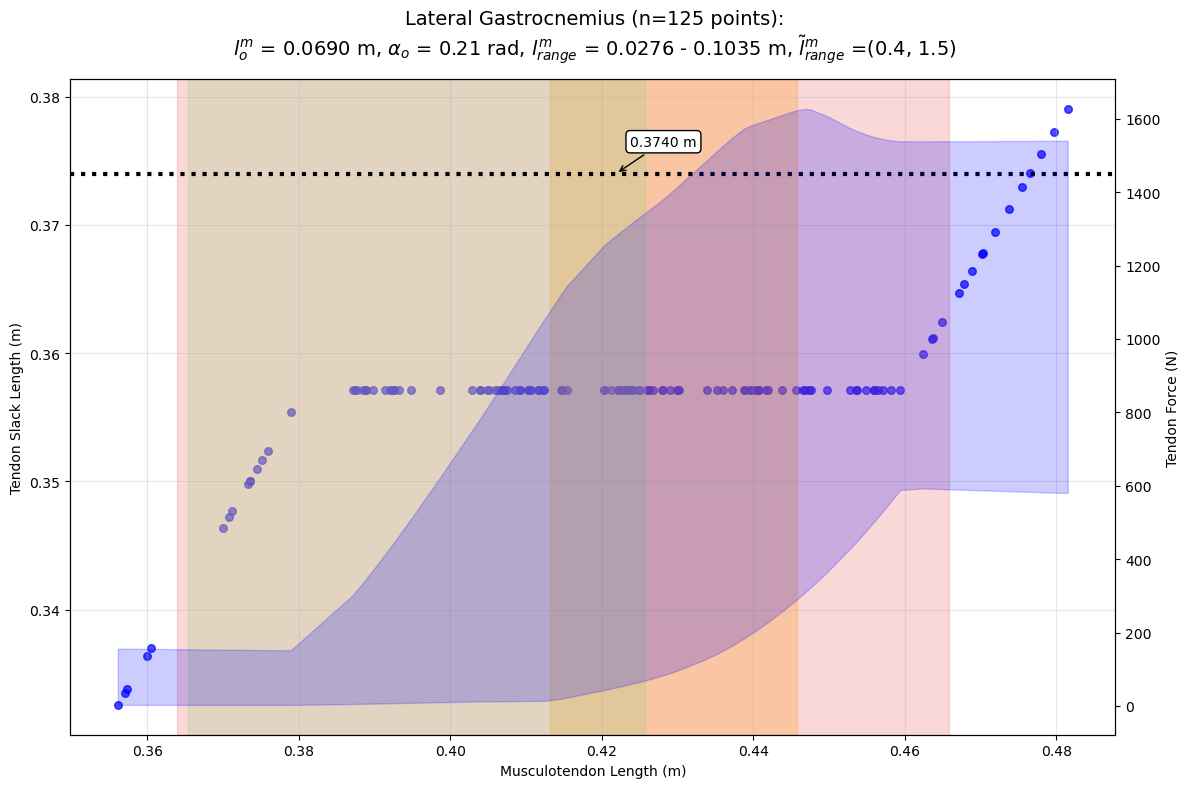

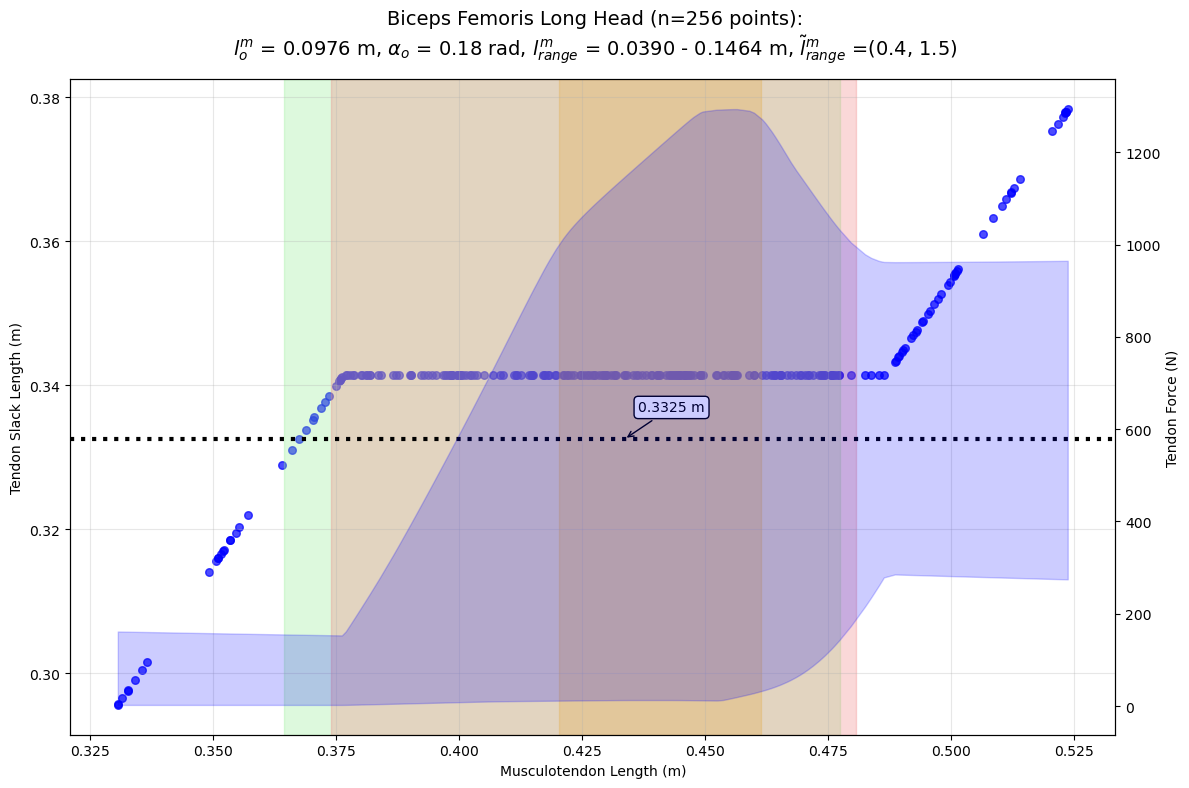

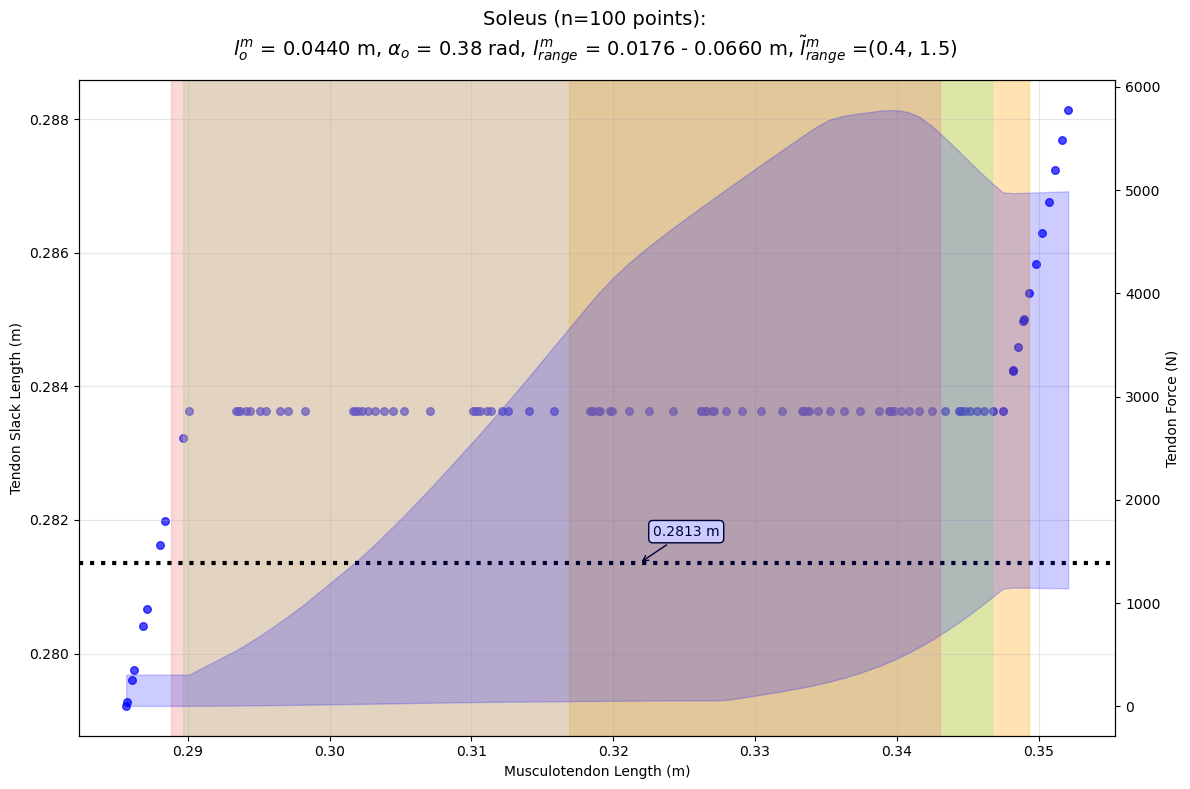

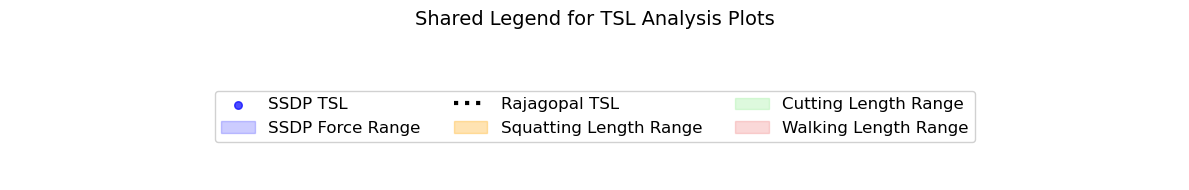


DETAILED TSL ESTIMATES ANALYSIS

GASLAT_R:
--------------------------------------------------
MT Length Range: 0.3561 - 0.4815 m
Number of MT Length Points: 125

SSDP:
  Number of TSL estimates: 125
  TSL range: 0.3326 - 0.3790 m
  TSL mean ± std: 0.3571 ± 0.0068 m
  TSL coefficient of variation: 1.89%

BFLH_R:
--------------------------------------------------
MT Length Range: 0.3307 - 0.5238 m
Number of MT Length Points: 256

SSDP:
  Number of TSL estimates: 256
  TSL range: 0.2956 - 0.3784 m
  TSL mean ± std: 0.3414 ± 0.0125 m
  TSL coefficient of variation: 3.66%

SOLEUS_R:
--------------------------------------------------
MT Length Range: 0.2857 - 0.3521 m
Number of MT Length Points: 100

SSDP:
  Number of TSL estimates: 100
  TSL range: 0.2792 - 0.2881 m
  TSL mean ± std: 0.2836 ± 0.0013 m
  TSL coefficient of variation: 0.47%

Total TSL-MT data points collected: 481

Correlation between MT Length and TSL estimates:
  gaslat_r: r = 0.7613
  bflh_r: r = 0.7670
  soleus_r: r = 0.

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Rajagopal's TSL estimates for comparison
rajagopal_tsl = {
    'gaslat_r': 0.374,
    'bflh_r': 0.33250000000000002,
    'soleus_r': 0.28134999999999999,
}

muscle_titles = {
    'gaslat_r': 'Lateral Gastrocnemius',
    'bflh_r': 'Biceps Femoris Long Head',
    'soleus_r': 'Soleus'
}

# Colors and markers for different objectives
objective_colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']

motion_colors = ['orange', 'lightgreen', 'lightcoral']

# Plot each muscle in a separate figure
muscle_names = list(muscles.keys())

# Create shared legend elements (we'll use the first muscle to generate legend handles)
legend_handles = []
legend_labels = []

for idx, muscle_name in enumerate(muscle_names):
    # Create a new figure for each muscle
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax2 = ax.twinx()
    
    # Get MT lengths used in optimization
    lmt_data = lengths[muscle_name].select(pl.col(muscle_name)).to_numpy().flatten()
    lmt_unique = np.clip(np.sort(np.unique(lmt_data)), 1e-6, None)
    
    # Plot TSL estimates for each objective
    for j, objective in enumerate(objectives.keys()):
        if objective not in muscle_data[muscle_name]:
            print(f"Warning: Objective '{objective}' not found for muscle '{muscle_name}'. Skipping.")
            continue
        tsl_result = muscle_data[muscle_name][objective]['tsl']

        scatter = ax.scatter(lmt_unique, tsl_result, color=objective_colors[j], marker=markers[j], 
                    s=30, alpha=0.7, label=f'{objective} TSL')
        
        min_force = muscle_data[muscle_name][objective]['min_force']
        max_force = muscle_data[muscle_name][objective]['max_force']
        fill = ax2.fill_between(lmt_unique, min_force, max_force, color=objective_colors[j], alpha=0.2, 
                        label=f'{objective} Force Range')
        
        # Collect legend handles for the first muscle only
        if idx == 0:
            legend_handles.extend([scatter, fill])
            legend_labels.extend([f'{objective} TSL', f'{objective} Force Range'])

    if muscle_name in rajagopal_tsl:
        tsl_value = rajagopal_tsl[muscle_name]
        line = ax.axhline(y=tsl_value, color='black', linestyle=':', linewidth=3,
                   label='Rajagopal TSL')
        
        # Annotate the Rajagopal TSL value on the plot
        ax.annotate(f'{tsl_value:.4f} m', 
                   xy=(lmt_unique.mean(), tsl_value), 
                   xytext=(10, 20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1.0),
                   arrowprops=dict(arrowstyle='->', color='black'),
                   fontsize=10, ha='left')
        
        # Add to legend for first muscle only
        if idx == 0:
            legend_handles.append(line)
            legend_labels.append('Rajagopal TSL')
        
    # Shade regions for the lengths in the motion data
    for motion_idx, (motion, motion_info) in enumerate(motion_data.items()):
        muscle_lengths = motion_info['muscles'].get(muscle_name, {}).get('lengths', None)
        if muscle_lengths is not None:
            min_length = muscle_lengths.select(pl.col(muscle_name)).min().item()
            max_length = muscle_lengths.select(pl.col(muscle_name)).max().item()
            span = ax.axvspan(min_length, max_length, color=motion_colors[motion_idx], alpha=0.3, 
                       label=f'{motion.title()} Length Range')
            
            # Add to legend for first muscle only
            if idx == 0:
                legend_handles.append(span)
                legend_labels.append(f'{motion.title()} Length Range')
        
    ax2.set_ylabel('Tendon Force (N)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    ax.set_xlabel('Musculotendon Length (m)')
    ax.set_ylabel('Tendon Slack Length (m)')
    
    # Use LaTeX formatting for subscript and superscript in the title
    fig.suptitle(
        # f'Tendon Slack Length Estimates vs Musculotendon Lengths\n'
        rf'{muscle_titles.get(muscle_name, muscle_name).title()} (n={len(lmt_unique)} points):'
        '\n'
        r'$l^{m}_{o}$ = '
        f'{muscle_data[muscle_name]["lm_opt"]:.4f} m, '
        r'$\alpha_{o}$ = '
        f'{muscle_data[muscle_name]["alpha_opt"]:.2f} rad, '
        r'$l^{m}_{range}$ = '
        f'{muscle_data[muscle_name]["lm_range"][0]:.4f} - {muscle_data[muscle_name]["lm_range"][1]:.4f} m, '
        r'$\tilde{l}^{m}_{range}$ =' f'{lm_norm_range}',
        fontsize=14
    )
    
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create a separate figure for the shared legend
if legend_handles:
    fig_legend, ax_legend = plt.subplots(figsize=(12, 2))
    ax_legend.axis('off')  # Hide the axes
    
    # Create the legend
    legend = ax_legend.legend(legend_handles, legend_labels, 
                             loc='center', ncol=len(legend_handles)//2, 
                             fontsize=12, frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    plt.title('Shared Legend for TSL Analysis Plots', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Create summary statistics for each muscle-objective combination
print("\n" + "="*80)
print("DETAILED TSL ESTIMATES ANALYSIS")
print("="*80)

summary_data = []
for muscle_name in muscle_names:
    lmt_data = lengths[muscle_name].select(pl.col(muscle_name)).to_numpy().flatten()
    lmt_unique = np.clip(np.sort(np.unique(lmt_data)), 1e-6, None)
    
    print(f"\n{muscle_name.upper()}:")
    print("-" * 50)
    print(f"MT Length Range: {lmt_unique.min():.4f} - {lmt_unique.max():.4f} m")
    print(f"Number of MT Length Points: {len(lmt_unique)}")
    
    for objective in objectives.keys():
        tsl_result = muscle_data[muscle_name][objective]['tsl']
        
        if hasattr(tsl_result, '__len__') and len(tsl_result) > 1:
            tsl_array = np.array(tsl_result)
            print(f"\n{objective}:")
            print(f"  Number of TSL estimates: {len(tsl_array)}")
            print(f"  TSL range: {tsl_array.min():.4f} - {tsl_array.max():.4f} m")
            print(f"  TSL mean ± std: {tsl_array.mean():.4f} ± {tsl_array.std():.4f} m")
            print(f"  TSL coefficient of variation: {tsl_array.std()/tsl_array.mean()*100:.2f}%")
            
            # Add to summary data
            if len(tsl_result) == len(lmt_unique):
                for mt_val, tsl_val in zip(lmt_unique, tsl_result):
                    summary_data.append({
                        'Muscle': muscle_name,
                        'Objective': objective,
                        'MT_Length': mt_val,
                        'TSL_Estimate': tsl_val
                    })
        else:
            print(f"\n{objective}: Single value = {float(tsl_result):.4f} m")

# Convert to DataFrame for easier analysis
if summary_data:
    df_summary = pd.DataFrame(summary_data)
    print(f"\nTotal TSL-MT data points collected: {len(df_summary)}")
    
    # Show correlation analysis
    print("\nCorrelation between MT Length and TSL estimates:")
    for muscle_name in muscle_names:
        summary_data = df_summary[df_summary['Muscle'] == muscle_name]
        if len(summary_data) > 1:
            correlation = summary_data['MT_Length'].corr(summary_data['TSL_Estimate'])
            print(f"  {muscle_name}: r = {correlation:.4f}")
else:
    print("\nNo array-based TSL estimates found for detailed analysis.")